#### ee23b110.ipynb
Roll No: EE23B110  
Name: Ishaan Seth  
Date: 6 Oct 2024    
Description: Generate a heatmap locating an approximate position of an obstacle using DAS Algorithm.
Inputs: rx2.txt, rx3.txt
Outputs: Plots for Positions, Microphone Outputs and Heatmap

# PART I. Manual Setup of Parameters and Known Obstacle Location

# 1. Setup Parameters:

In [15]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Define System Parameters
Nmics = 64            # Number of microphones
Nsamp = 200          # Number of time samples
pitch = 0.1          # Spacing between microphones (units)
C = 0.5              # Speed of sound in the medium (units per second)
SincP = 1.0          # Time dilation factor for sinc pulse

# Source and Obstacle Locations
src = (0, 0)         # Source coordinates
obstacle = (3, -1)   # Obstacle coordinates (x > 0)

# 2. Setup Positions and Visualisation:

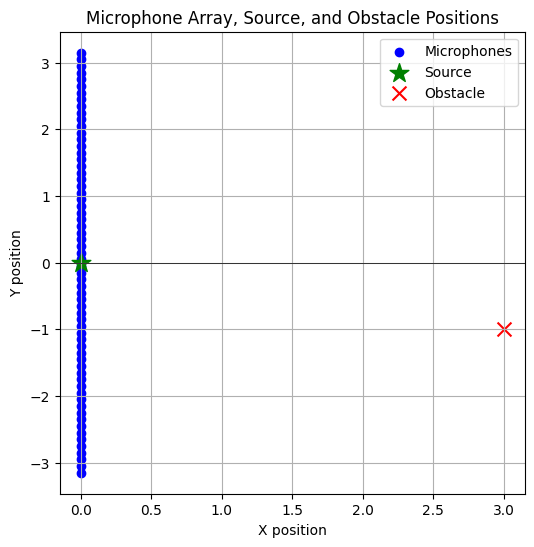

In [16]:
# Define Microphone Positions
mic_y_positions = np.linspace(
    - (Nmics / 2 - 0.5) * pitch,
      (Nmics / 2 - 0.5) * pitch,
    Nmics
)

mic_positions = np.zeros((Nmics, 2))
mic_positions[:, 0] = 0            # x-coordinates
mic_positions[:, 1] = mic_y_positions  # y-coordinates

# Visualize Microphone Positions, Source, and Obstacle
plt.figure(figsize=(6, 6))
plt.scatter(mic_positions[:,0], mic_positions[:,1], color='blue', label='Microphones')
plt.scatter(src[0], src[1], color='green', marker='*', s=200, label='Source')
plt.scatter(obstacle[0], obstacle[1], color='red', marker='x', s=100, label='Obstacle')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Microphone Array, Source, and Obstacle Positions')
plt.legend()
plt.grid(True)
plt.show()

# 3. Distance Calculation for Source-Obstacle-Mic Path:

In [17]:
# Define the Reconstruction Grid
x_min = 0
x_max = 6
Nx = 100             # Number of points along the X-axis

y_min = -2          # Extended to include the obstacle at y=-1
y_max = 2
Ny = 100            # Number of points along the Y-axis

# Generate grid points
x_points = np.linspace(x_min, x_max, Nx)
y_points = np.linspace(y_min, y_max, Ny)

# Create meshgrid for reconstruction
X, Y = np.meshgrid(x_points, y_points)

# Define the Distance Function
# Function to calculate total distance from source to a grid point to microphone
def dist(src, pt, mic):
    # Distance from source to point
    d1 = np.sqrt((pt[0] - src[0])**2 + (pt[1] - src[1])**2)
    # Distance from point to microphone
    d2 = np.sqrt((mic[0] - pt[0])**2 + (mic[1] - pt[1])**2)
    return d1 + d2

# 4. Sinc Pulse Generation for Source Sound Wave:

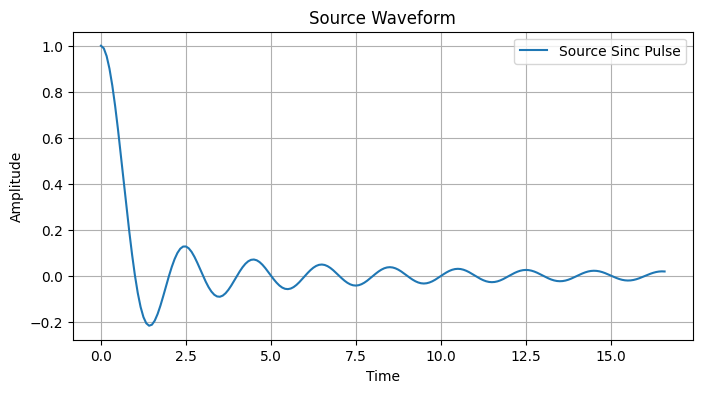

In [18]:
# Generate the Source Waveform
# Compute maximum distance sound travels: from source to obstacle to farthest microphone
max_distance = np.sqrt((obstacle[0] - src[0])**2 + (obstacle[1] - src[1])**2) + \
               np.sqrt((obstacle[0] - mic_positions[:,0])**2 + (obstacle[1] - mic_positions[:,1])**2).max()

# Total time required for the signal to travel this distance
t_max = max_distance / C

# Time interval between samples
delta_t = t_max / Nsamp

# Time axis from 0 to t_max
t = np.linspace(0, t_max, Nsamp)

# Define the source waveform - sinc pulse centered at t=0
def wsrc(t):
    return np.sinc(SincP * t)

wsrc_values = wsrc(t)

# Plot the Source Waveform
plt.figure(figsize=(8, 4))
plt.plot(t, wsrc_values, label='Source Sinc Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Source Waveform')
plt.legend()
plt.grid(True)
plt.show()

# 5. Generate Microphone Outputs:

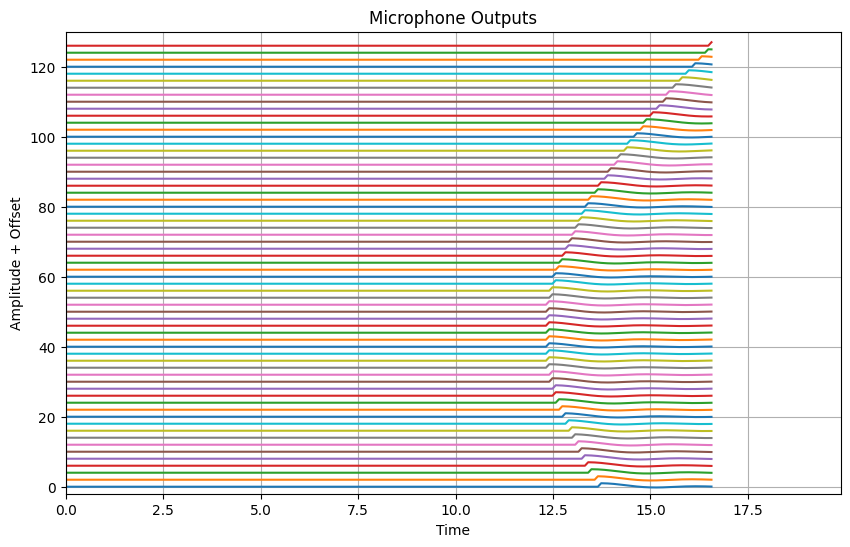

In [19]:
# Generate Microphone Outputs
# Initialize microphone outputs array
mic_signals = np.zeros((Nmics, Nsamp))

for m in range(Nmics):
    mic_pos = mic_positions[m]
    d_total = dist(src, obstacle, mic_pos)  # Total distance for reflection
    tdelay = d_total / C                    # Time delay
    t_source = t - tdelay                   # Time when the source emitted the signal
    # Interpolate the source waveform at the calculated times
    mic_signals[m, :] = np.interp(
        t_source, t, wsrc_values, left=0, right=0
    )

plt.figure(figsize=(10, 6))
for mic_idx in range(Nmics):
    plt.plot(t, mic_signals[mic_idx] + mic_idx * 2)
plt.xlabel('Time')
plt.ylabel('Amplitude + Offset')
plt.title('Microphone Outputs')
plt.xlim(t.min(), t.max() * 1.2)  # Extended x-axis
plt.ylim(-2, Nmics * 2 + 2)
plt.grid(True)
plt.show()

# 6. Generate Heatmap of Microphone Outputs:

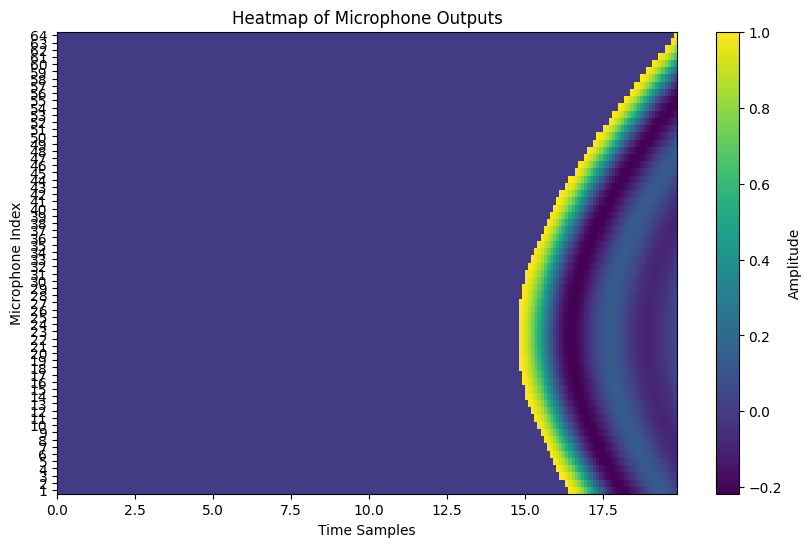

In [20]:
# Heatmap of Microphone Outputs Using Matplotlib's imshow
plt.figure(figsize=(10, 6))
plt.imshow(
    mic_signals,
    aspect='auto',
    cmap='viridis',
    extent=[0, t.max() * 1.2, 0, Nmics],
    origin='lower'
)
plt.colorbar(label='Amplitude')
plt.xlabel('Time Samples')
plt.ylabel('Microphone Index')
plt.title('Heatmap of Microphone Outputs')
plt.yticks(ticks=np.arange(0.5, Nmics + 0.5), labels=np.arange(1, Nmics + 1))
plt.xlim(0, t.max() * 1.2)  # Extended x-axis
plt.ylim(0, Nmics)
plt.show()

# 7. Delay-and-Sum (DAS) Algorithm for Image Reconstruction:

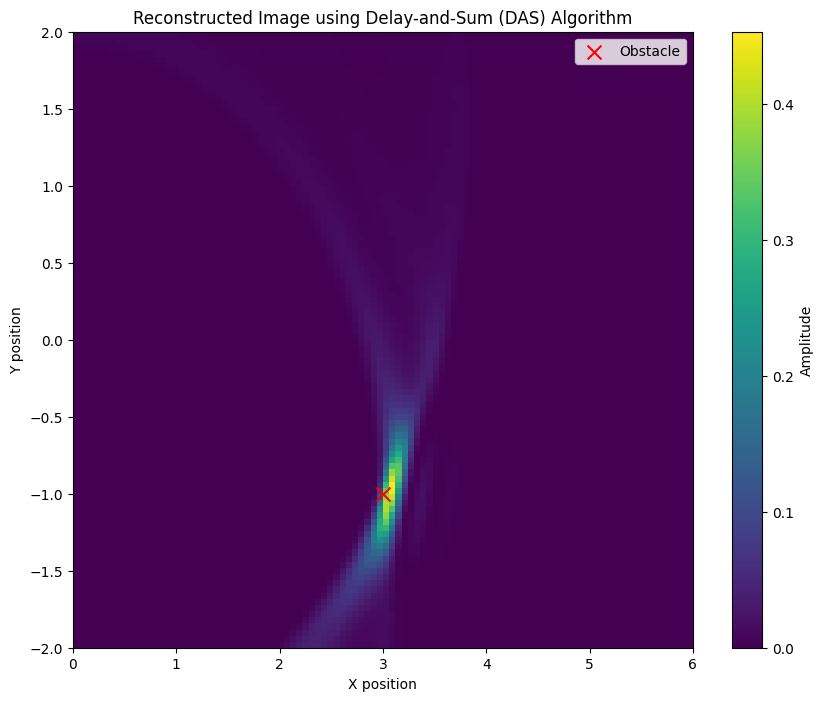

In [21]:
# Initialize the reconstructed image
reconstructed_image = np.zeros((Ny, Nx))

# Implement DAS as per the user's specified algorithm
for ix, x in enumerate(x_points):
    for iy, y in enumerate(y_points):
        total_signal = 0
        for mic_idx, mic in enumerate(mic_positions):
            # Calculate total distance from source to (x, y) to mic
            delay_dist = dist(src, (x, y), mic)
            # Calculate delay in samples
            delay_samples = int(delay_dist / (C * delta_t))
            # Add the microphone output at the delayed sample if within range
            if delay_samples < Nsamp:
                total_signal += mic_signals[mic_idx, delay_samples]
        # Assign the total signal to the reconstructed image
        reconstructed_image[iy, ix] = total_signal

# Normalize the reconstructed image
reconstructed_image /= Nmics  # Average the sum

# Apply Gaussian smoothing
sigma = 1.0  # Standard deviation for Gaussian kernel
image_smoothed = gaussian_filter(reconstructed_image, sigma=sigma)

# Enhance contrast using non-linear scaling (e.g., squaring the values)
image_enhanced = np.power(image_smoothed, 2)

# Plot the enhanced and smoothed reconstructed image
plt.figure(figsize=(10, 8))
plt.imshow(
    image_enhanced,
    extent=[x_min, x_max, y_min, y_max],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)
plt.colorbar(label='Amplitude')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Reconstructed Image using Delay-and-Sum (DAS) Algorithm')
plt.scatter(
    obstacle[0], obstacle[1],
    color='red', marker='x', s=100, label='Obstacle'
)
plt.legend()
plt.show()

# Part II. Finding Location of Obstacle using Heatmap and Datasets rx2.txt and rx3.txt

# 1. Load Datasets

In [22]:
# Load datasets rx2.txt and rx3.txt
mic_signals_rx2 = np.loadtxt('rx2.txt')  # Shape: (64, 200)
mic_signals_rx3 = np.loadtxt('rx3.txt')  # Shape: (64, 200)

# 2. Plot Microphone Outputs and Heatmap for rx2.txt

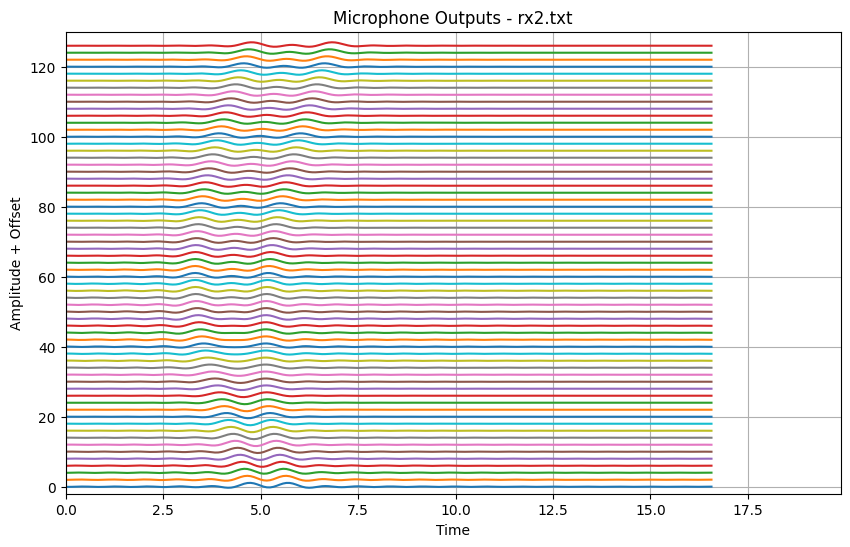

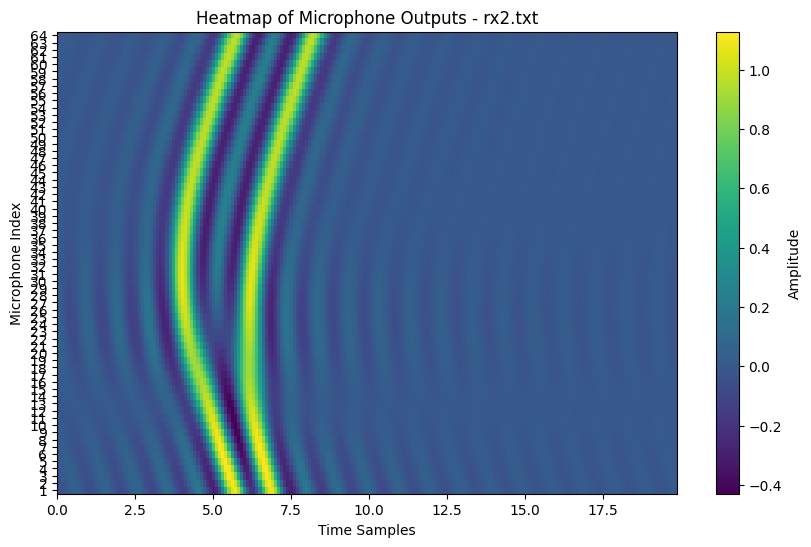

In [23]:
# Plot Microphone Outputs for rx2.txt with Offsets
plt.figure(figsize=(10, 6))
for mic_idx in range(Nmics):
    plt.plot(t, mic_signals_rx2[mic_idx] + mic_idx * 2)
plt.xlabel('Time')
plt.ylabel('Amplitude + Offset')
plt.title('Microphone Outputs - rx2.txt')
plt.xlim(t.min(), t.max() * 1.2)  # Extended x-axis
plt.ylim(-2, Nmics * 2 + 2)
plt.grid(True)
plt.show()

# Heatmap of Microphone Outputs - rx2.txt
plt.figure(figsize=(10, 6))
plt.imshow(
    mic_signals_rx2,
    aspect='auto',
    cmap='viridis',
    extent=[0, t.max() * 1.2, 0, Nmics],
    origin='lower'
)
plt.colorbar(label='Amplitude')
plt.xlabel('Time Samples')
plt.ylabel('Microphone Index')
plt.title('Heatmap of Microphone Outputs - rx2.txt')
plt.yticks(ticks=np.arange(0.5, Nmics + 0.5), labels=np.arange(1, Nmics + 1))
plt.xlim(0, t.max() * 1.2)  # Extended x-axis
plt.ylim(0, Nmics)
plt.show()

# 3. Plot Microphone Outputs and Heatmap for rx3.txt


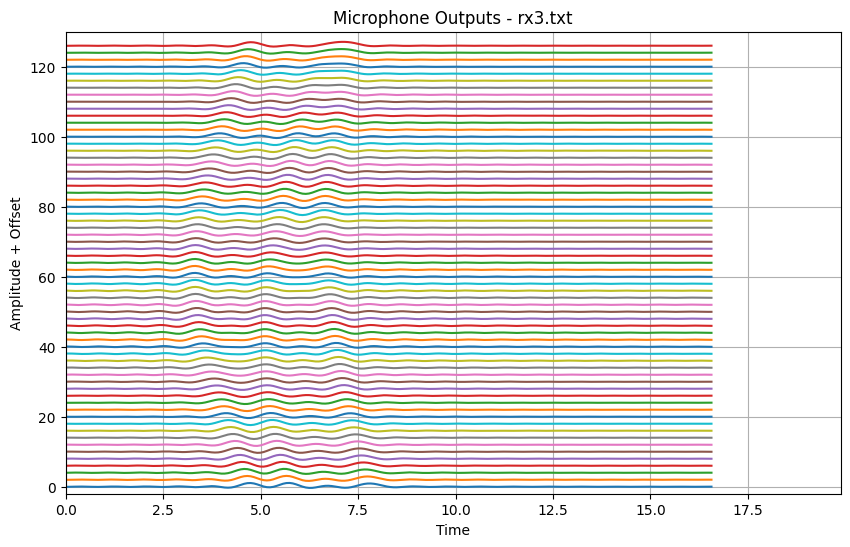

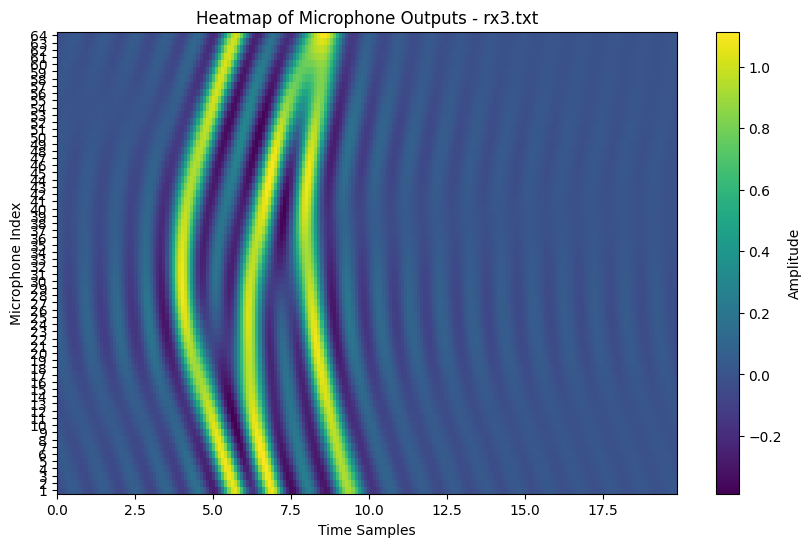

In [24]:
# Plot Microphone Outputs for rx3.txt with Offsets
plt.figure(figsize=(10, 6))
for mic_idx in range(Nmics):
    plt.plot(t, mic_signals_rx3[mic_idx] + mic_idx * 2)
plt.xlabel('Time')
plt.ylabel('Amplitude + Offset')
plt.title('Microphone Outputs - rx3.txt')
plt.xlim(t.min(), t.max() * 1.2)  # Extended x-axis
plt.ylim(-2, Nmics * 2 + 2)
plt.grid(True)
plt.show()

# Heatmap of Microphone Outputs - rx3.txt
plt.figure(figsize=(10, 6))
plt.imshow(
    mic_signals_rx3,
    aspect='auto',
    cmap='viridis',
    extent=[0, t.max() * 1.2, 0, Nmics],
    origin='lower'
)
plt.colorbar(label='Amplitude')
plt.xlabel('Time Samples')
plt.ylabel('Microphone Index')
plt.title('Heatmap of Microphone Outputs - rx3.txt')
plt.yticks(ticks=np.arange(0.5, Nmics + 0.5), labels=np.arange(1, Nmics + 1))
plt.xlim(0, t.max() * 1.2)  # Extended x-axis
plt.ylim(0, Nmics)
plt.show()

# 4. Delay-and-Sum (DAS) Algorithm for Image Reconstruction:

In [25]:
# Function to perform DAS and reconstruct image
def perform_das(mic_signals, t, mic_positions, src, x_points, y_points, C, delta_t, Nmics, Nx, Ny):
    # Initialize the reconstructed image
    reconstructed_image = np.zeros((Ny, Nx))
    
    # Implement DAS
    for ix, x in enumerate(x_points):
        for iy, y in enumerate(y_points):
            total_signal = 0
            for mic_idx, mic in enumerate(mic_positions):
                # Calculate total distance from source to (x, y) to mic
                delay_dist = dist(src, (x, y), mic)
                # Calculate delay in samples
                delay_samples = int(delay_dist / (C * delta_t))
                # Add the microphone output at the delayed sample if within range
                if delay_samples < Nsamp:
                    total_signal += mic_signals[mic_idx, delay_samples]
            # Assign the total signal to the reconstructed image
            reconstructed_image[iy, ix] = total_signal
    
    # Normalize the reconstructed image
    reconstructed_image /= Nmics  # Average the sum
    
    # Apply Gaussian smoothing
    sigma = 1.0  # Standard deviation for Gaussian kernel
    image_smoothed = gaussian_filter(reconstructed_image, sigma=sigma)
    
    # Enhance contrast using non-linear scaling (e.g., squaring the values)
    image_enhanced = np.power(image_smoothed, 2)
    
    return image_enhanced

# 6. Reconstruct Image for rx2.txt

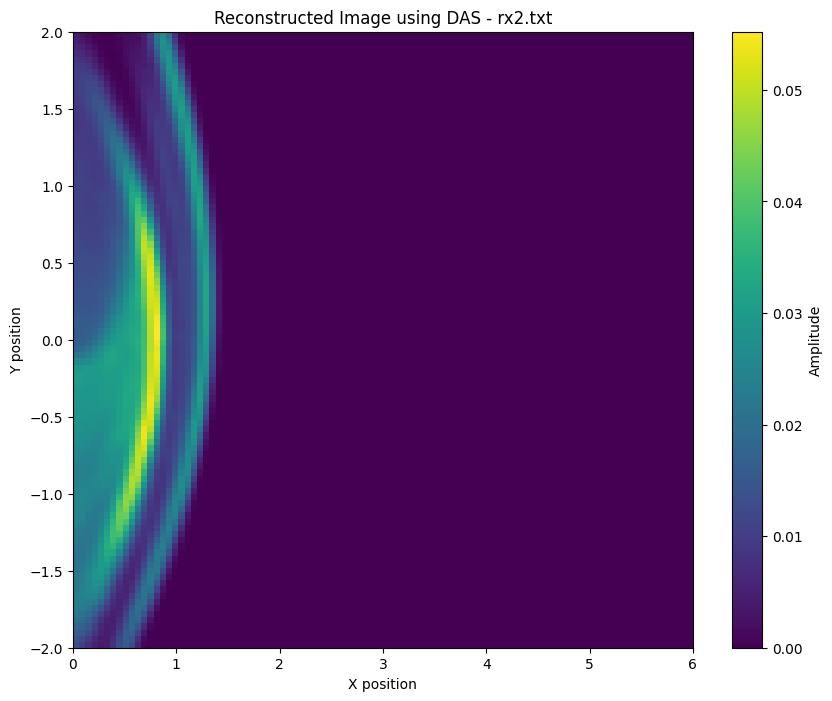

In [26]:
# Perform DAS on rx2.txt
reconstructed_image_rx2 = perform_das(mic_signals_rx2, t, mic_positions, src, x_points, y_points, C, delta_t, Nmics, Nx, Ny)

# Plot the reconstructed image for rx2.txt
plt.figure(figsize=(10, 8))
plt.imshow(
    reconstructed_image_rx2,
    extent=[x_min, x_max, y_min, y_max],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)
plt.colorbar(label='Amplitude')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Reconstructed Image using DAS - rx2.txt')
plt.show()

# 7. Reconstruct Image for rx3.txt

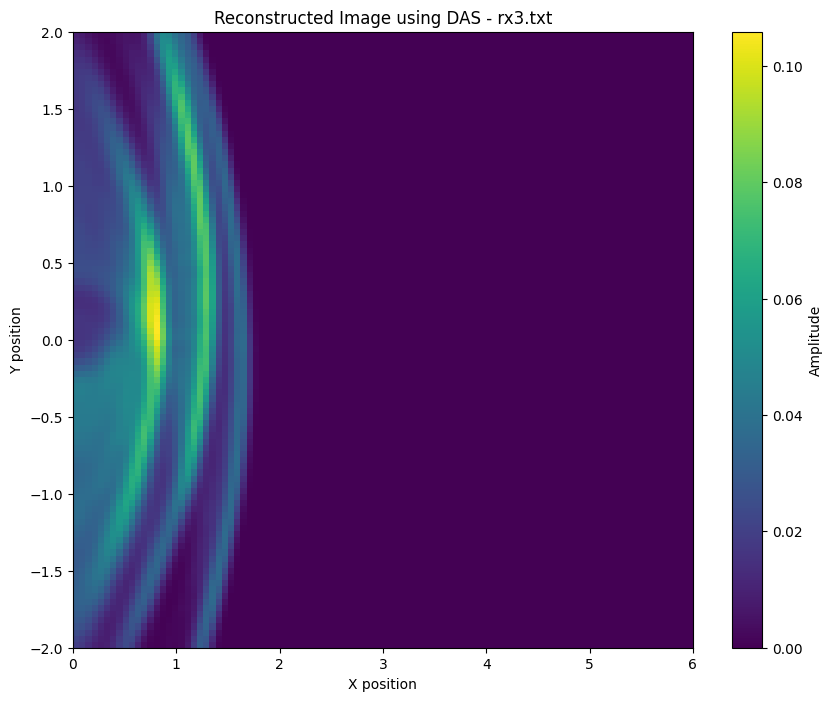

In [27]:
# Perform DAS on rx3.txt
reconstructed_image_rx3 = perform_das(mic_signals_rx3, t, mic_positions, src, x_points, y_points, C, delta_t, Nmics, Nx, Ny)

# Plot the reconstructed image for rx3.txt
plt.figure(figsize=(10, 8))
plt.imshow(
    reconstructed_image_rx3,
    extent=[x_min, x_max, y_min, y_max],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)
plt.colorbar(label='Amplitude')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Reconstructed Image using DAS - rx3.txt')
plt.show()